<a href="https://colab.research.google.com/github/iasolb/ECON3916-Statistics-MachineLearning/blob/main/Assignment%201/Econ_3916_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ECON3916 Assignment 1
- Ian Solberg
- January 20, 2026

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
student_basket = [
    {'Item': 'Tuition', 'Price_2016': 45000, 'Price_2024': 58000},
    {'Item': 'Rent (1 Bed)', 'Price_2016': 1200, 'Price_2024': 1800},
    {'Item': 'Chipotle Burrito', 'Price_2016': 7.50, 'Price_2024': 11.50},
    {"Item": "Coffee Beans", "Price_2016": 15, 'Price_2024': 20}
]

def calculate_inflation(base, current):
    return ((current - base) / base) * 100

for item in student_basket:
    rate = calculate_inflation(item['Price_2016'], item['Price_2024'])
    print(f"{item['Item']}: {rate:.2f}% Inflation")

Tuition: 28.89% Inflation
Rent (1 Bed): 50.00% Inflation
Chipotle Burrito: 53.33% Inflation
Coffee Beans: 33.33% Inflation


## FRED call

In [4]:
!pip install fredapi
from fredapi import Fred
fred = Fred(api_key='8de61e4a49d7c25c75aca7eaae2eafa5')

official_cpi = fred.get_series('CPIAUCSL', observation_start='2016-01-01')
tuition = fred.get_series('CUSR0000SEEB', observation_start='2016-01-01')
rent = fred.get_series('CUSR0000SEHA', observation_start='2016-01-01')
cable_tv = fred.get_series('CUSR0000SERA02', observation_start='2016-01-01')
fafh = fred.get_series('CUSR0000SEFV', observation_start='2016-01-01')

dct = {
    'cpi': official_cpi,
    'tuition': tuition,
    'rent': rent,
    'cable': cable_tv,
    'food_away_from_home': fafh
}

def get_value_index(val_current: float, val_at_start_date: float) -> float:
  return (val_current /val_at_start_date) * 100

In [5]:
df = pd.DataFrame(dct)
df.head()

,cpi,tuition,rent,cable,food_away_from_home
2016-01-01,237.652,699.997,291.700,427.538,259.958
2016-02-01,237.336,701.688,292.617,430.633,260.319
2016-03-01,238.080,703.289,293.471,433.738,260.883
2016-04-01,238.992,704.842,294.397,435.570,261.517
2016-05-01,239.557,706.506,295.371,437.005,262.074


In [6]:
df_indexed = df.apply(lambda col: get_value_index(col, col.iloc[0]))
df_indexed.head()


,cpi,tuition,rent,cable,food_away_from_home
2016-01-01,100.000000,100.000000,100.000000,100.000000,100.000000
2016-02-01,99.867032,100.241572,100.314364,100.723912,100.138869
2016-03-01,100.180095,100.470288,100.607131,101.450163,100.355827
2016-04-01,100.563850,100.692146,100.924580,101.878663,100.599712
2016-05-01,100.801592,100.929861,101.258485,102.214306,100.813978


<Axes: >

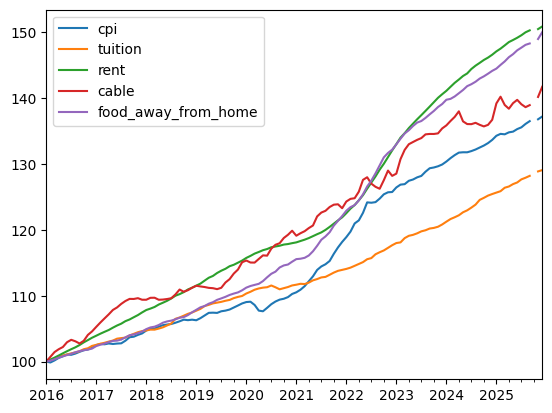

In [7]:
df_indexed.plot()

In [8]:
spi_weighting_dct = {
    "Tuition": 0.4,
    "Rent (1 Bed)": 0.3,
    "Chipotle Burrito": 0.15,
    "Coffee Beans": 0.15
}

In [9]:
student_basket

[{'Item': 'Tuition', 'Price_2016': 45000, 'Price_2024': 58000},
 {'Item': 'Rent (1 Bed)', 'Price_2016': 1200, 'Price_2024': 1800},
 {'Item': 'Chipotle Burrito', 'Price_2016': 7.5, 'Price_2024': 11.5},
 {'Item': 'Coffee Beans', 'Price_2016': 15, 'Price_2024': 20}]

In [10]:
def weight_cost(price: float, weight: float) -> float:
  return price * weight

In [11]:
from typing import DefaultDict
dct = DefaultDict(float)

for item in student_basket:
  item_name = item["Item"]
  item_weight = spi_weighting_dct[item_name]
  baseprice = item['Price_2016']
  currentprice = item["Price_2024"]
  adjusted_base = weight_cost(baseprice, item_weight)
  adjusted_current = weight_cost(currentprice, item_weight)
  dct[item_name] = [adjusted_base, adjusted_current]

spi_base = 0
spi_current = 0
for i in dct:
  base = dct[i][0]
  current = dct[i][1]
  spi_base += base
  spi_current += current

spi_totals = {"2016": spi_base, "2024": spi_current}
for key, val in spi_totals.items():
  print(f"Year: {key} Weighted Total: {val}")

indexed_spi_base = get_value_index(spi_totals["2016"], spi_totals["2016"])
indexed_spi_current = get_value_index(spi_totals["2024"], spi_totals["2016"])
print(f"Indexed Values to 2016 \n 2016: {indexed_spi_base} \n 2024: {indexed_spi_current}")


df_indexed["Student_SPI"] = np.nan
df_indexed.iloc[0, df_indexed.columns.get_loc("Student_SPI")] = indexed_spi_base
df_indexed.iloc[-1, df_indexed.columns.get_loc("Student_SPI")] = indexed_spi_current
df_indexed["Student_SPI"] = df_indexed["Student_SPI"].interpolate(method='linear')
df_indexed.head()

Year: 2016 Weighted Total: 18363.375
Year: 2024 Weighted Total: 23744.725
Indexed Values to 2016 
 2016: 100.0 
 2024: 129.3047982737378


,cpi,tuition,rent,cable,food_away_from_home,Student_SPI
2016-01-01,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2016-02-01,99.867032,100.241572,100.314364,100.723912,100.138869,100.246259
2016-03-01,100.180095,100.470288,100.607131,101.450163,100.355827,100.492518
2016-04-01,100.563850,100.692146,100.924580,101.878663,100.599712,100.738776
2016-05-01,100.801592,100.929861,101.258485,102.214306,100.813978,100.985035


In [12]:
good = df_indexed[["cpi", "Student_SPI"]]
bad = df[["tuition","cable"]]

In [19]:
def plot_time_series(data, x1, x2) -> plt.figure:
    plt.figure(figsize=(12, 6))

    sns.lineplot(data=data, x=data.index, y=x1, label=x1)
    sns.lineplot(data=data, x=data.index, y=x2, label=x2)

    plt.fill_between(data.index, data[x1], data[x2], alpha=0.3)

    plt.title(f"Official CPI and Custom SPI Over Time")
    plt.xlabel(data.index.name if data.index.name else "Index")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()

    return plt.figure


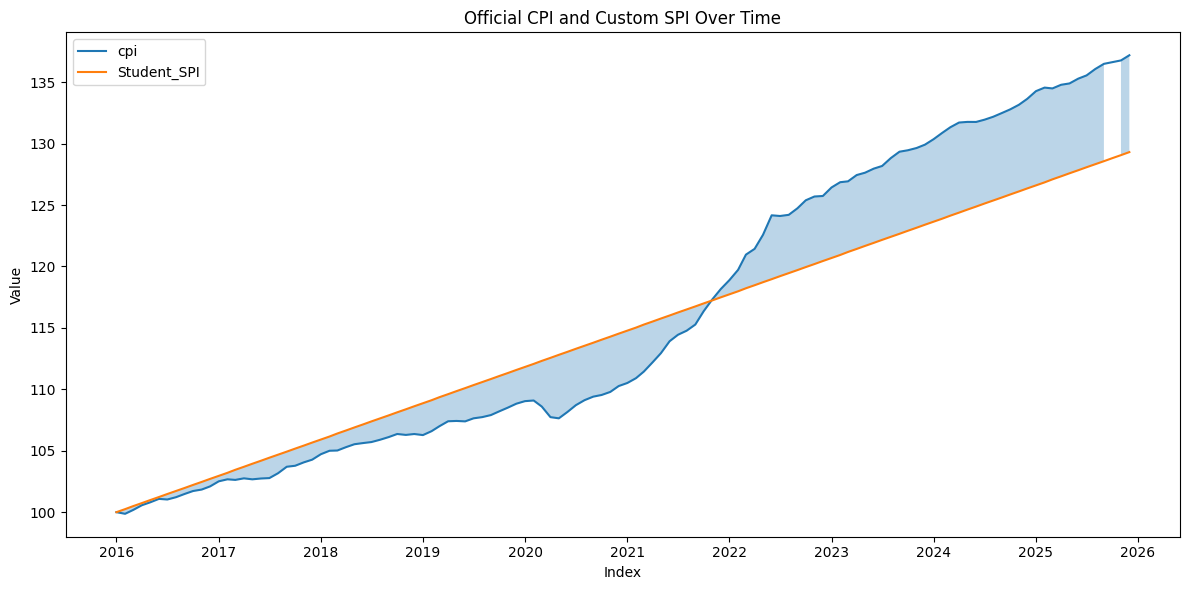

In [22]:
plot_time_series(good, "cpi", "Student_SPI");